# 온라인 스토어 유저 데이터 EDA
## 데이터 설명
- `2020-09-24 ~ 2020-12-21`에 걸쳐 일어난 온라인 스토어 유저 데이터
- 컬럼 설명
    - `event_time` : 이벤트 발생 시간 로그
    - `month` : 이벤트 발생 월
    - `day` : 이벤트 발생 일
    - `day_name` : 이벤트 발생 요일
    - `hour` : 이벤트 발생 시간
    - `event_type` : 발생한 이벤트 (view, cart, purchase)
    - `product_id` : 제품 id
    - `category_id` : 제품이 속한 카테고리 id
    - `category_code` : 제품이 속한 카테고리 코드
    - `price` : 가격
    - `user_id` : 로그인한 유저 id
    - `user_session` : 유저가 활동한 세션
    - `cat_code_1` : 대분류
    - `cat_code_2` : 중분류
    - `cat_code_3` : 소분류

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from datetime import datetime
from datetime import timedelta
import missingno as msno

from plotly import graph_objects as go
import plotly.express as px

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
original_path = "data/events.csv"
file_path = "data/df_preprocessed.csv"
original_df = pd.read_csv(original_path)
df = pd.read_csv(file_path)
# df.drop(['index'], axis = 1, inplace = True)
df.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.9,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,poHN5cBucr,computers,notebook,no_cat


In [3]:
df["event_time"] = pd.to_datetime(df["event_time"])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 407913 entries, 0 to 407912
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype              
---  ------         --------------   -----              
 0   event_time     407913 non-null  datetime64[ns, UTC]
 1   month          407913 non-null  int64              
 2   day            407913 non-null  int64              
 3   day_name       407913 non-null  object             
 4   hour           407913 non-null  int64              
 5   event_type     407913 non-null  object             
 6   product_id     407913 non-null  int64              
 7   category_id    407913 non-null  float64            
 8   category_code  407913 non-null  object             
 9   brand          407913 non-null  object             
 10  price          407913 non-null  float64            
 11  user_id        407913 non-null  float64            
 12  user_session   407913 non-null  object             
 13  cat_code_1     407913 non-nul

In [5]:
# 결측치 확인
df.isnull().sum()

event_time       0
month            0
day              0
day_name         0
hour             0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
cat_code_1       0
cat_code_2       0
cat_code_3       0
dtype: int64

### `.describe()` 확인
- `price` 컬럼 평균 약 125.67인 것에 비해, max 값이 약 64771
    - 이상치가 크다
- `event_type` 컬럼 가장 많은 값 `view`
- `category_code` 컬럼 가장 많은 값 `electronics.telephone`
- `brand` 컬럼 가장 많은 값 `samsung`
- `user_session` 컬럼 `count`는 407913 인 것에 비해 `unique`는 234135
    - `user_session` 여러개 잡힌 사람들 존재
    - 가장 오래 활동한 `user_session : 9HqvxzKlPb`

In [6]:
df.describe()

,month,day,hour,product_id,category_id,price,user_id
count,407913.000000,407913.000000,407913.000000,4.079130e+05,4.079130e+05,407913.000000,4.079130e+05
mean,10.770439,15.558948,12.352386,1.883717e+06,2.140011e+18,125.672520,1.520000e+18
std,0.854003,8.603416,5.404243,1.425949e+06,8.122978e+14,313.322016,8.678923e+06
min,9.000000,1.000000,0.000000,8.540000e+02,2.140000e+18,0.900000,1.520000e+18
25%,10.000000,8.000000,8.000000,7.431800e+05,2.140000e+18,25.860000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.443880e+06,2.140000e+18,58.780000,1.520000e+18
75%,11.000000,23.000000,17.000000,3.658540e+06,2.140000e+18,146.920000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183872e+06,2.230000e+18,64771.060000,1.520000e+18


In [7]:
df.describe(include="object")

,day_name,event_type,category_code,brand,user_session,cat_code_1,cat_code_2,cat_code_3
count,407913,407913,407913,407913,407913,407913,407913,407913
unique,7,3,107,945,234135,14,42,78
top,Monday,view,electronics.telephone,samsung,9HqvxzKlPb,computers,components,no_cat
freq,64724,367166,63645,15203,424,164793,79230,153112


### 오리지널 데이터셋과 전처리 거친 데이터셋 컬럼 비교
- 결측치 발견되었던 `category_code`, `brand` 컬럼 비율을 비교해본다

In [8]:
# 오리지널 데이터셋 category_code 비율 TOP 15
ori_cat = original_df["category_code"].value_counts(normalize=True)[:15]
ori_cat_df = pd.DataFrame({"ori_cat_code" : ori_cat}).reset_index()
ori_cat_df

,category_code,ori_cat_code
0,electronics.telephone,0.143986
1,computers.peripherals.printer,0.079135
2,computers.components.videocards,0.077924
3,stationery.cartrige,0.072676
4,electronics.audio.acoustic,0.044925
5,computers.notebook,0.044063
6,computers.components.cpu,0.041934
7,computers.components.motherboard,0.041357
8,electronics.video.tv,0.035294
9,electronics.tablet,0.033637


In [9]:
# 전처리 거친 데이터셋 category_code 비율 TOP 15
preprocessed_cat = df["category_code"].value_counts(normalize=True)[:15]
preprocessed_cat_df = pd.DataFrame({"preprocessed_cat_code" : preprocessed_cat}).reset_index()
preprocessed_cat_df

,category_code,preprocessed_cat_code
0,electronics.telephone,0.156026
1,computers.peripherals.printer,0.076543
2,stationery.cartrige,0.073567
3,computers.components.videocards,0.065173
4,computers.notebook,0.052288
5,electronics.audio.acoustic,0.048275
6,electronics.tablet,0.037741
7,computers.components.cpu,0.036579
8,computers.components.motherboard,0.036172
9,electronics.video.tv,0.032561


In [10]:
# 오리지널 데이터셋 brand 비율 TOP 35
ori_brand = original_df["brand"].value_counts(normalize=True)[:35]
ori_brand_df = pd.DataFrame({"ori_brand" : ori_brand}).reset_index()
ori_brand_df

,brand,ori_brand
0,samsung,0.036109
1,amd,0.032861
2,asus,0.031627
3,canon,0.031516
4,gigabyte,0.023102
5,hp,0.019877
6,panasonic,0.019551
7,sirius,0.019117
8,pioneer,0.019040
9,msi,0.016268


In [11]:
# 전처리 거친 데이터셋 category_code 비율 TOP 35
preprocessed_brand = df["brand"].value_counts(normalize=True)[:35]
preprocessed_brand_df = pd.DataFrame({"preprocessed_brand" : preprocessed_brand}).reset_index()
preprocessed_brand_df

,brand,preprocessed_brand
0,samsung,0.037270
1,amd,0.029582
2,sirius,0.029041
3,asus,0.029026
4,canon,0.027763
5,hp,0.021387
6,gigabyte,0.020970
7,palit,0.018548
8,palmexx,0.018528
9,pioneer,0.017389


In [12]:
# category_code Top 15가 오리지널 데이터셋에서 차지하는 비율 : 71%
print("category_code Top 15가 오리지널 데이터셋에서 차지하는 비율 :", round(np.sum(ori_cat_df["ori_cat_code"]) * 100), "%")

category_code Top 15가 오리지널 데이터셋에서 차지하는 비율 : 71 %


In [13]:
# category_code Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 71%
print("category_code Top 15가 전처리 거친 데이터셋에서 차지하는 비율 :", round(np.sum(preprocessed_cat_df["preprocessed_cat_code"]) * 100), "%")

category_code Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 71 %


In [14]:
# brand Top 15가 오리지널 데이터셋에서 차지하는 비율 : 71%
print("brand Top 15가 오리지널 데이터셋에서 차지하는 비율 :", round(np.sum(ori_brand_df["ori_brand"]) * 100), "%")

brand Top 15가 오리지널 데이터셋에서 차지하는 비율 : 51 %


In [15]:
# brand Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 71%
print("brand Top 15가 전처리 거친 데이터셋에서 차지하는 비율 :", round(np.sum(preprocessed_brand_df["preprocessed_brand"]) * 100), "%")

brand Top 15가 전처리 거친 데이터셋에서 차지하는 비율 : 51 %


#### 시각화 (오리지널, 전처리)

In [16]:
# 오리지널, 전처리 거친 데이터셋 category_code Top 15 비교 위해 두 데이터셋 합친 데이터프레임 새로 생성
feature_contrast = pd.merge(ori_cat, preprocessed_cat, how="inner", on="category_code")
feature_contrast.columns = ["original_rate", "preprocessed_rate"]
# feature_contrast = feature_contrast.sort_values(by="original_rate")
feature_contrast


,original_rate,preprocessed_rate
category_code,,
electronics.telephone,0.143986,0.156026
computers.peripherals.printer,0.079135,0.076543
computers.components.videocards,0.077924,0.065173
stationery.cartrige,0.072676,0.073567
electronics.audio.acoustic,0.044925,0.048275
computers.notebook,0.044063,0.052288
computers.components.cpu,0.041934,0.036579
computers.components.motherboard,0.041357,0.036172
electronics.video.tv,0.035294,0.032561


In [17]:
# 오리지널, 전처리 거친 데이터셋 brand Top 35 비교 위해 두 데이터셋 합친 데이터프레임 새로 생성
feature_contrast_br = pd.merge(ori_brand, preprocessed_brand, how="inner", on="brand")
feature_contrast_br.columns = ["original_rate", "preprocessed_rate"]
# feature_contrast_br = feature_contrast_br.sort_values(by="original_rate")
feature_contrast_br


,original_rate,preprocessed_rate
brand,,
samsung,0.036109,0.037270
amd,0.032861,0.029582
asus,0.031627,0.029026
canon,0.031516,0.027763
gigabyte,0.023102,0.020970
hp,0.019877,0.021387
panasonic,0.019551,0.016464
sirius,0.019117,0.029041
pioneer,0.019040,0.017389


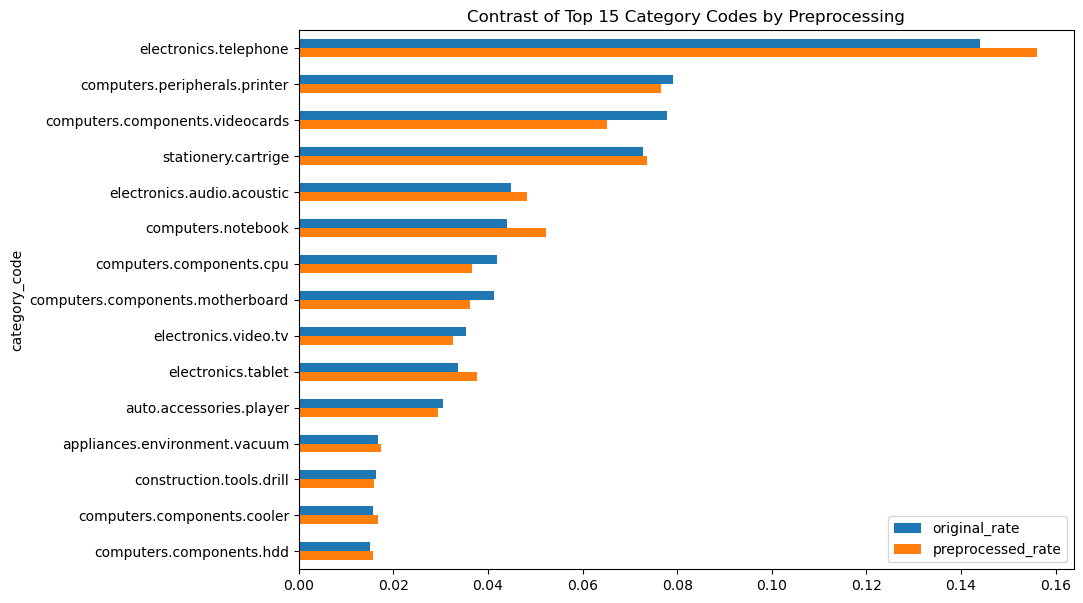

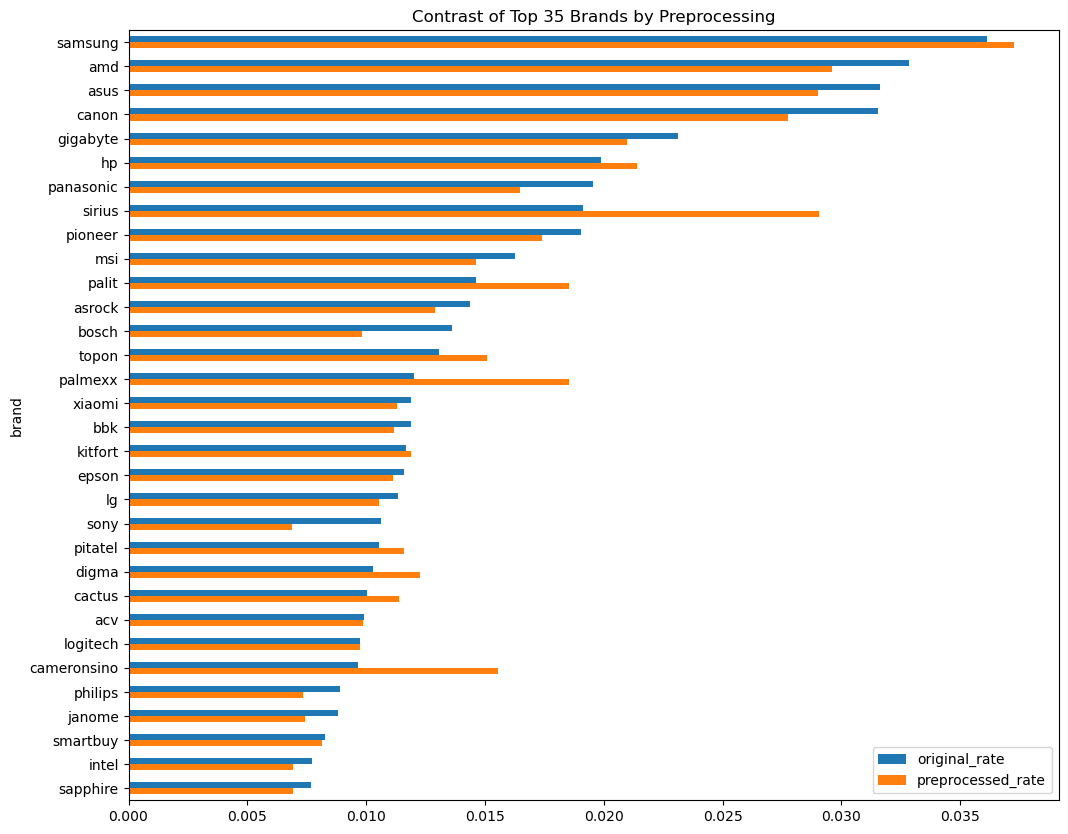

In [18]:
# 오리지널, 전처리 거친 데이터셋 category_code Top 15 비교 시각화
# 오리지널, 전처리 거친 데이터셋 brand Top 35 비교 시각화

f1 = feature_contrast.plot.barh(figsize=(10, 7))
f2 = feature_contrast_br.plot.barh(figsize=(12, 10))

f1.set_title("Contrast of Top 15 Category Codes by Preprocessing")
f2.set_title("Contrast of Top 35 Brands by Preprocessing")

f1.invert_yaxis()
f2.invert_yaxis()

In [19]:
# 오리지날, 전처리 후 브랜드 비율 차이 크게 나는 것들 자세히 비교
# 차이나는 비율이 엄청 크지는 않다

# 브랜드들 검색 조건
# sirius, palit, palmexx, cameronsino
or_br_contrast_cond = (ori_brand_df["brand"] == "sirius") | (ori_brand_df["brand"] == "palit") | (ori_brand_df["brand"] == "palmexx") | (ori_brand_df["brand"] == "cameronsino")

pre_br_contrast_cond = (preprocessed_brand_df["brand"] == "sirius") | (preprocessed_brand_df["brand"] == "palit") | (preprocessed_brand_df["brand"] == "palmexx") | (preprocessed_brand_df["brand"] == "cameronsino")

# 브랜드 검색 조건으로 필터링한 데이터프레임들 merge해서 새로운 데이터프레임 생성
diff_df = pd.merge(ori_brand_df[or_br_contrast_cond], preprocessed_brand_df[pre_br_contrast_cond])

# 전처리한 데이터 - 오리지널 데이터 빼서 차이 확인
diff_df["difference"] = diff_df["preprocessed_brand"] - diff_df["ori_brand"]
diff_df

,brand,ori_brand,preprocessed_brand,difference
0,sirius,0.019117,0.029041,0.009923
1,palit,0.014608,0.018548,0.003940
2,palmexx,0.012032,0.018528,0.006497
3,cameronsino,0.009662,0.015557,0.005895


#### 시각화 결과 
-전처리 한 컬럼 시각화 결과, 오리지널 데이터와 크게 차이나지 않는 것 확인

### 이상치 확인

In [20]:
# 참고 : https://statisticsbyjim.com/basics/remove-outliers/ 
# 참고 : https://statisticsbyjim.com/basics/outliers/

In [21]:
df[df.category_code == "electronics.telephone"].describe()

,month,day,hour,product_id,category_id,price,user_id
count,63645.000000,63645.000000,63645.000000,6.364500e+04,6.364500e+04,63645.000000,6.364500e+04
mean,10.739555,15.490848,12.310614,2.342269e+06,2.140000e+18,68.177481,1.520000e+18
std,0.850167,8.635620,5.455147,1.352118e+06,3.963856e+13,133.443476,6.479411e+05
min,9.000000,1.000000,0.000000,8.540000e+02,2.140000e+18,1.570000,1.520000e+18
25%,10.000000,8.000000,8.000000,1.153852e+06,2.140000e+18,16.510000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.812603e+06,2.140000e+18,29.680000,1.520000e+18
75%,11.000000,22.000000,17.000000,3.828043e+06,2.140000e+18,61.100000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183870e+06,2.150000e+18,1790.030000,1.520000e+18


In [22]:
original_df[(original_df.category_code == "electronics.telephone") & (original_df.price >= 1790)]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
18532,2020-09-28 23:57:10 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,CyjmerMc3I
22119,2020-09-29 16:29:50 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,kiLi35onu9
50757,2020-10-06 04:31:23 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,VWv8RTZuHA
59907,2020-10-08 03:34:06 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,uSNPJdfSEV
72374,2020-10-11 04:38:32 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW
72375,2020-10-11 04:39:00 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW
163093,2020-10-27 13:40:18 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,UyowYgd8qi
230710,2020-11-07 12:50:22 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,acTfIF225C
235202,2020-11-08 08:39:48 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,7Mgk9nKqve
240584,2020-11-09 02:33:19 UTC,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,Xh49RwBNrm


In [23]:
df[(df.category_code == "electronics.telephone") & (df.price >= 1790)]


,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
339911,2020-09-28 23:57:10+00:00,9,28,Monday,23,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,CyjmerMc3I,electronics,telephone,no_cat
339912,2020-09-29 16:29:50+00:00,9,29,Tuesday,16,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,kiLi35onu9,electronics,telephone,no_cat
339913,2020-10-06 04:31:23+00:00,10,6,Tuesday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,VWv8RTZuHA,electronics,telephone,no_cat
339914,2020-10-08 03:34:06+00:00,10,8,Thursday,3,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,uSNPJdfSEV,electronics,telephone,no_cat
339915,2020-10-11 04:38:32+00:00,10,11,Sunday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW,electronics,telephone,no_cat
339916,2020-10-11 04:39:00+00:00,10,11,Sunday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW,electronics,telephone,no_cat
339917,2020-10-27 13:40:18+00:00,10,27,Tuesday,13,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,UyowYgd8qi,electronics,telephone,no_cat
339918,2020-11-07 12:50:22+00:00,11,7,Saturday,12,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,acTfIF225C,electronics,telephone,no_cat
339919,2020-11-08 08:39:48+00:00,11,8,Sunday,8,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,7Mgk9nKqve,electronics,telephone,no_cat
339920,2020-11-09 02:33:19+00:00,11,9,Monday,2,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,Xh49RwBNrm,electronics,telephone,no_cat


In [24]:
df[(df.category_code == "electronics.telephone") & (df.price >= 1790)]

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
339911,2020-09-28 23:57:10+00:00,9,28,Monday,23,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,CyjmerMc3I,electronics,telephone,no_cat
339912,2020-09-29 16:29:50+00:00,9,29,Tuesday,16,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,kiLi35onu9,electronics,telephone,no_cat
339913,2020-10-06 04:31:23+00:00,10,6,Tuesday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,VWv8RTZuHA,electronics,telephone,no_cat
339914,2020-10-08 03:34:06+00:00,10,8,Thursday,3,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,uSNPJdfSEV,electronics,telephone,no_cat
339915,2020-10-11 04:38:32+00:00,10,11,Sunday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW,electronics,telephone,no_cat
339916,2020-10-11 04:39:00+00:00,10,11,Sunday,4,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,RJw9AOiLiW,electronics,telephone,no_cat
339917,2020-10-27 13:40:18+00:00,10,27,Tuesday,13,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,UyowYgd8qi,electronics,telephone,no_cat
339918,2020-11-07 12:50:22+00:00,11,7,Saturday,12,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,acTfIF225C,electronics,telephone,no_cat
339919,2020-11-08 08:39:48+00:00,11,8,Sunday,8,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,7Mgk9nKqve,electronics,telephone,no_cat
339920,2020-11-09 02:33:19+00:00,11,9,Monday,2,view,3556458,2.140000e+18,electronics.telephone,samsung,1790.03,1.520000e+18,Xh49RwBNrm,electronics,telephone,no_cat


In [25]:
df[(df.brand == "apple")]["category_code"].value_counts()

category_code
computers.notebook                      274
electronics.tablet                      121
computers.peripherals.printer            90
computers.peripherals.keyboard           24
electronics.audio.headphone              19
electronics.video.tv                     13
computers.peripherals.mouse              10
computers.components.network_adapter      9
computers.peripherals.camera              7
stationery.cartrige                       3
construction.tools.saw                    2
electronics.audio.acoustic                1
electronics.telephone                     1
Name: count, dtype: int64

In [26]:
# df[(df.category_code == "electronics.telephone") & (df.price >= 1790)]
df[(df.category_code == "electronics.telephone") & (df.brand == "apple")]


,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
322479,2020-12-05 17:53:04+00:00,12,5,Saturday,17,view,4099105,2.140000e+18,electronics.telephone,apple,52.44,1.520000e+18,eCLXAyOWTM,electronics,telephone,no_cat


In [27]:
df[(df.category_code == "computers.notebook") & (df.brand == "apple")].describe()

,month,day,hour,product_id,category_id,price,user_id
count,274.000000,274.000000,274.000000,2.740000e+02,2.740000e+02,274.000000,2.740000e+02
mean,10.759124,16.405109,12.445255,2.979588e+06,2.140000e+18,2415.948175,1.520000e+18
std,0.910062,9.160761,5.437517,1.487062e+06,0.000000e+00,1100.879456,0.000000e+00
min,9.000000,1.000000,0.000000,2.749890e+05,2.140000e+18,72.020000,1.520000e+18
25%,10.000000,9.000000,8.000000,9.121860e+05,2.140000e+18,1089.620000,1.520000e+18
50%,11.000000,17.000000,12.500000,4.013319e+06,2.140000e+18,3138.300000,1.520000e+18
75%,11.000000,25.000000,17.000000,4.101673e+06,2.140000e+18,3267.060000,1.520000e+18
max,12.000000,31.000000,23.000000,4.171191e+06,2.140000e+18,4280.920000,1.520000e+18


In [28]:
df[df.brand == "samsung"].describe()

,month,day,hour,product_id,category_id,price,user_id
count,15203.000000,15203.000000,15203.000000,1.520300e+04,1.520300e+04,15203.000000,1.520300e+04
mean,10.761166,15.607183,12.341972,2.198652e+06,2.140000e+18,201.819262,1.520000e+18
std,0.850013,8.572904,5.513311,1.331812e+06,4.574870e+05,816.583106,3.404912e+04
min,9.000000,1.000000,0.000000,4.220000e+03,2.140000e+18,1.570000,1.520000e+18
25%,10.000000,8.000000,8.000000,9.575860e+05,2.140000e+18,21.630000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.814282e+06,2.140000e+18,57.620000,1.520000e+18
75%,11.000000,23.000000,17.000000,3.642317e+06,2.140000e+18,205.490000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183836e+06,2.140000e+18,42590.130000,1.520000e+18


In [29]:
df[df.cat_code_1 == "computers"].describe()

,month,day,hour,product_id,category_id,price,user_id
count,164793.000000,164793.000000,164793.000000,1.647930e+05,1.647930e+05,164793.000000,1.647930e+05
mean,10.805562,15.520162,12.405994,1.876205e+06,2.140005e+18,154.170638,1.520000e+18
std,0.860274,8.565946,5.405063,1.475307e+06,3.807996e+14,356.533499,2.222087e+06
min,9.000000,1.000000,0.000000,1.357000e+03,2.140000e+18,1.570000,1.520000e+18
25%,10.000000,8.000000,8.000000,6.823210e+05,2.140000e+18,31.750000,1.520000e+18
50%,11.000000,16.000000,12.000000,1.355099e+06,2.140000e+18,77.730000,1.520000e+18
75%,11.000000,22.000000,17.000000,3.790736e+06,2.140000e+18,204.290000,1.520000e+18
max,12.000000,31.000000,23.000000,4.183872e+06,2.220000e+18,64771.060000,1.520000e+18


In [30]:
df.select_dtypes(include=np.number).columns.tolist()

['month', 'day', 'hour', 'product_id', 'category_id', 'price', 'user_id']

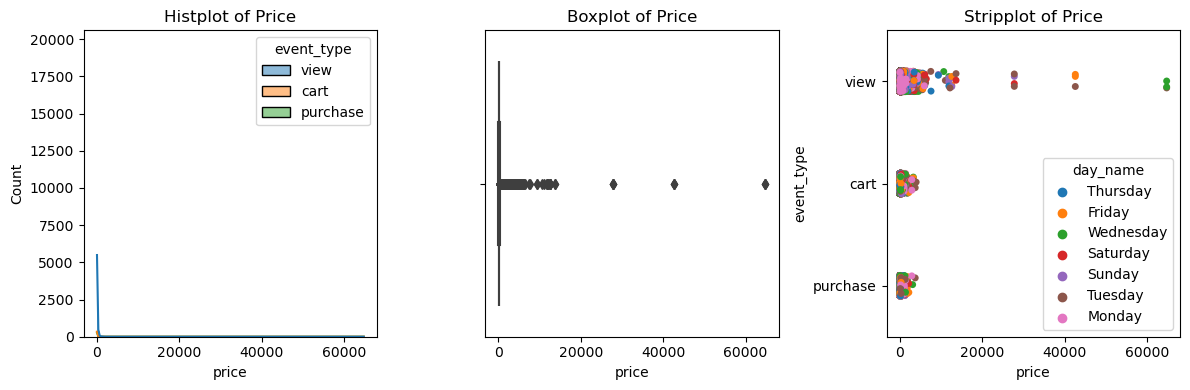

In [31]:
nrows, ncols = 1, 3
_, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

p1 = sns.histplot(data=df, x="price", kde=True, hue="event_type", ax=axes[0])
p2 = sns.boxplot(data=df, x="price", hue="event_type", ax=axes[1])
# p3 = sns.stripplot(data=df, x="event_type", y="price", hue="day_name", ax=axes[2])
p3 = sns.stripplot(data=df, x="price", y="event_type", hue="day_name", ax=axes[2])

p1.set_title("Histplot of Price")
p2.set_title("Boxplot of Price")
p3.set_title("Stripplot of Price")

plt.tight_layout()
plt.show()

In [32]:
# https://bigdaheta.tistory.com/82
QR1 = df[["price"]].quantile(q=0.25)
QR3 = df[["price"]].quantile(q=0.75)
print(QR1) 
print(QR3)

price    25.86
Name: 0.25, dtype: float64
price    146.92
Name: 0.75, dtype: float64


In [33]:
IQR = QR3-QR1
IQR

price    121.06
dtype: float64

In [34]:
IQR_df = df[(df['price'] <= QR3['price']+1.5*IQR['price']) & (df['price'] >= QR1['price']-1.5*IQR['price'])]
IQR_df

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.90,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.90,1.520000e+18,poHN5cBucr,computers,notebook,no_cat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407902,2020-12-21 09:32:28+00:00,12,21,Monday,9,view,905345,2.140000e+18,computers.peripherals.mouse,logitech,103.46,1.520000e+18,y24eJpmfbj,computers,peripherals,mouse
407909,2020-12-21 13:46:48+00:00,12,21,Monday,13,view,1012989,2.140000e+18,electronics.video.tv,hyundai,126.03,1.520000e+18,5ZMDadMXkO,electronics,video,tv
407910,2020-12-21 15:31:58+00:00,12,21,Monday,15,view,3605780,2.140000e+18,accessories.bag,thermos,8.81,1.520000e+18,PYjvdxNImA,accessories,bag,no_cat
407911,2020-12-21 16:11:25+00:00,12,21,Monday,16,view,1652970,2.140000e+18,electronics.video.tv,samsung,297.37,1.520000e+18,CICmjyK027,electronics,video,tv


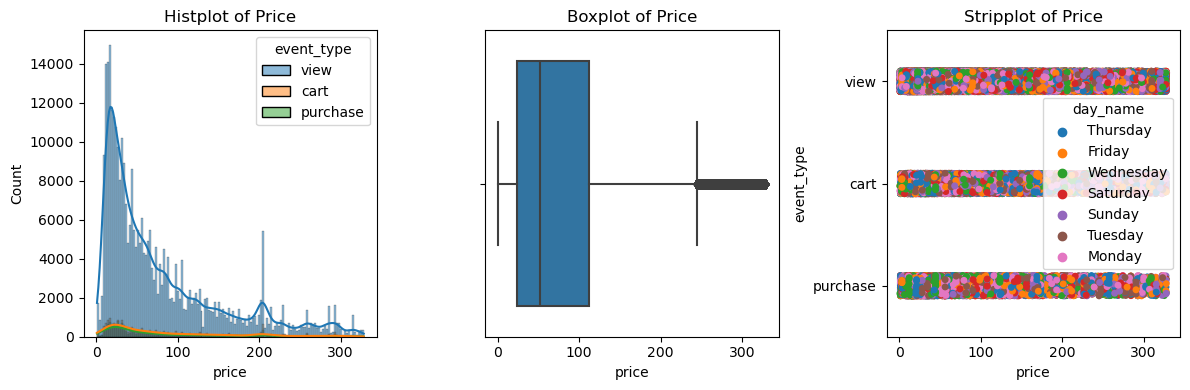

In [35]:
nrows, ncols = 1, 3
_, axes = plt.subplots(nrows, ncols, figsize=(12, 4))

p1 = sns.histplot(data=IQR_df, x="price", kde=True, hue="event_type", ax=axes[0])
p2 = sns.boxplot(data=IQR_df, x="price", hue="event_type", ax=axes[1])
# p3 = sns.stripplot(data=IQR_df, x="event_type", y="price", hue="day_name", ax=axes[2])
p3 = sns.stripplot(data=IQR_df, x="price", y="event_type", hue="day_name", ax=axes[2])

p1.set_title("Histplot of Price")
p2.set_title("Boxplot of Price")
p3.set_title("Stripplot of Price")

plt.tight_layout()
plt.show()

## event_type 분석

### event_type 분포

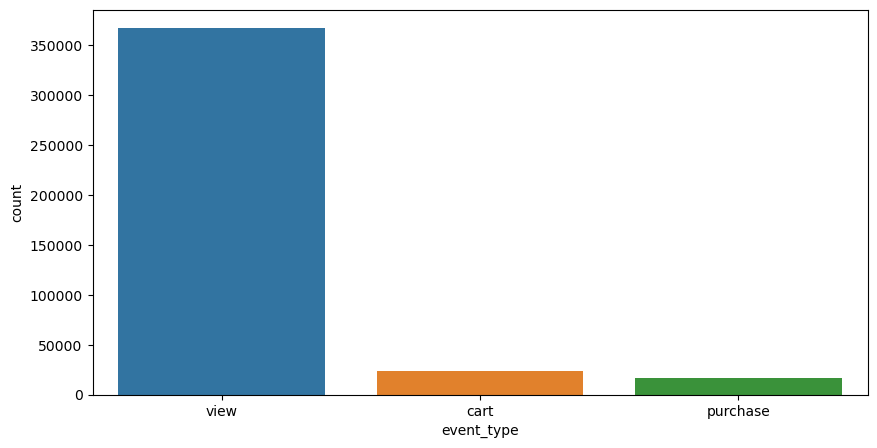

In [36]:
# event_type 분포
plt.figure(figsize=(10, 5))
cnt = sns.countplot(x=df["event_type"])
plt.show()

In [37]:
df["event_type"].value_counts(normalize=True)

event_type
view        0.900109
cart        0.058179
purchase    0.041712
Name: proportion, dtype: float64

### 요일별 고객 행동 분석

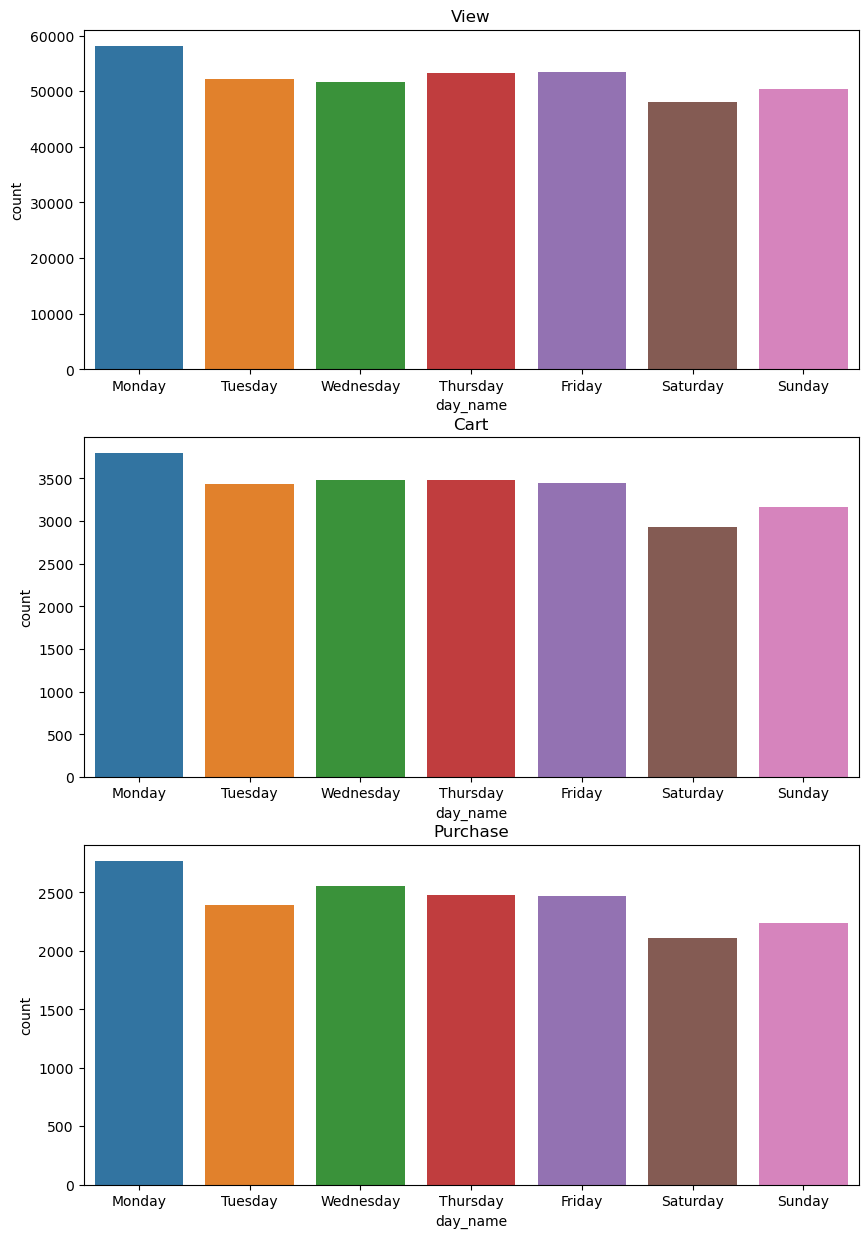

In [38]:
# 상품 클릭, 장바구니, 구매 조건 설정
view_cond = (df["event_type"] == "view")
cart_cond = (df["event_type"] == "cart")
purchase_cond = (df["event_type"] == "purchase")

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 요일별 상품 클릭한 숫자
view_cnt = sns.countplot(x=df[view_cond]["day_name"],
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],              
                         ax=ax[0])
view_cnt.set_title("View")

# 요일별 장바구니에 넣은 숫자
cart_cnt = sns.countplot(x=df[cart_cond]["day_name"],
                         order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                         ax=ax[1])
cart_cnt.set_title("Cart")

# 요일별 구매한 숫자
purchase_cnt = sns.countplot(x=df[purchase_cond]["day_name"],
                             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                             ax=ax[2])
purchase_cnt.set_title("Purchase")

plt.show()

### 시간대별 고객 행동 시각화

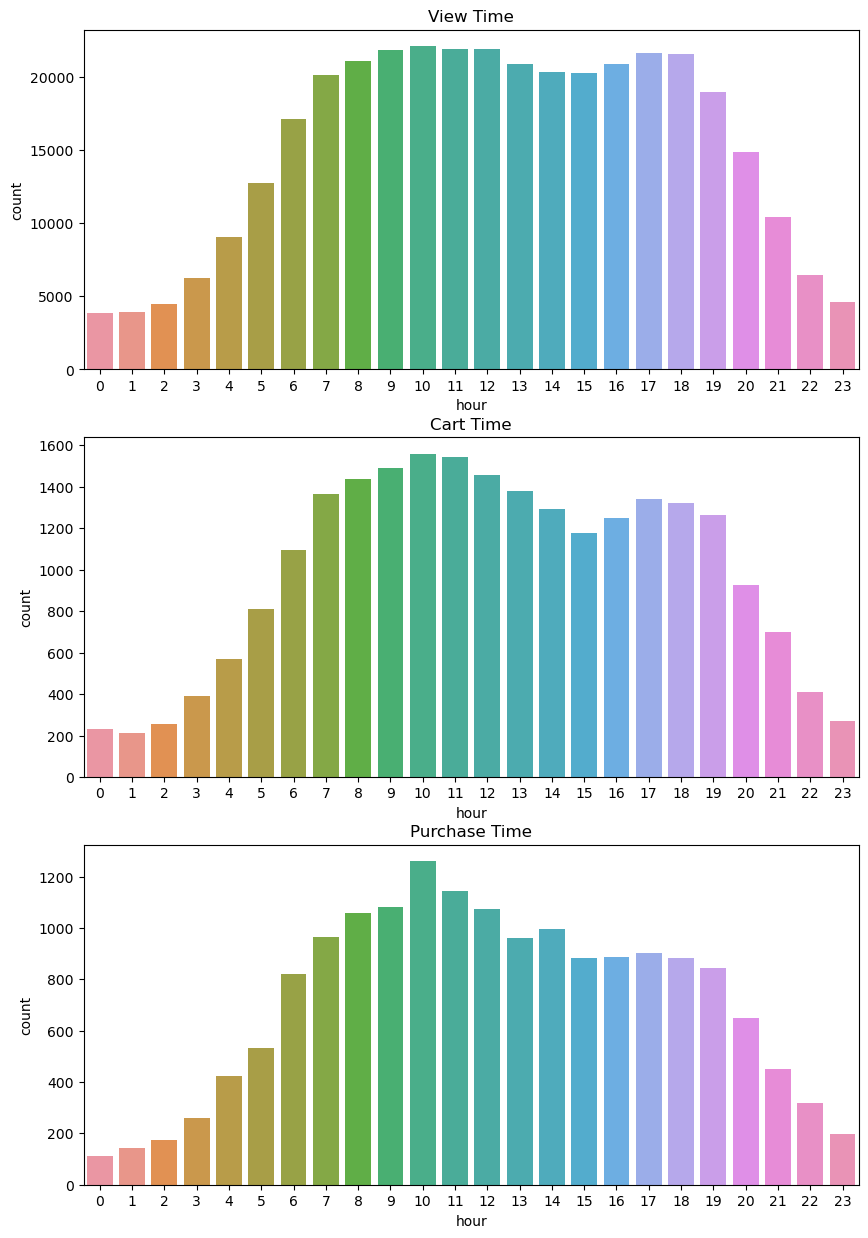

In [39]:
# 시간대별 View, Cart, Purchase

# 조건별로 countplot 생성
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

# 시간별 상품 클릭한 숫자
view_time_cnt = sns.countplot(x=df[view_cond]["hour"],
                              ax=ax[0])
view_time_cnt.set_title("View Time")

# 시간별 장바구니에 넣은 숫자
cart_time_cnt = sns.countplot(x=df[cart_cond]["hour"],
                         ax=ax[1])
cart_time_cnt.set_title("Cart Time")

# 시간별 구매한 숫자
purchase_time_cnt = sns.countplot(x=df[purchase_cond]["hour"],
                             ax=ax[2])
purchase_time_cnt.set_title("Purchase Time")

plt.show()

## 구매전환율 (CVR, Conversion Rate) 구하기
- 사이트에 들어온 방문자가 실제 구매 활동을 하는 비율

- 구매전환율 = 전환수(구매횟수) / 클릭수 * 100

In [40]:
df_copy = df.copy()
# DatetimeIndex를 PeriodIndex로 변환 (e.g. 2020-09-24)
df_copy['event_time'] =  df_copy['event_time'].dt.to_period('D')

# event_type = view인 user_session
df_view = df_copy.loc[df_copy['event_type']=='view']
df_view = df_view[['event_time','user_session','price']]

# event_type = view인 user_session
df_pur = df_copy.loc[df_copy['event_type']=='purchase']
df_pur = df_pur[['event_time','user_session','price']]

In [41]:
df_pur.head(3)

,event_time,user_session,price
31,2020-11-01,4vnP07gr9T,31.9
33,2020-11-01,4vnP07gr9T,31.9
41,2020-11-11,ZpTyn0xUox,31.9


In [42]:
# event_time을 기준으로, view한 횟수 계산
df_date_view = df_view.groupby('event_time').count().reset_index()
# event_time을 기준으로, purchase한 횟수 계산
df_date_purchase = df_pur.groupby('event_time').count().reset_index()

# groupby한 두 개의 데이터프레임 merge
df_cvr = pd.merge(df_date_view,df_date_purchase, on='event_time')

# cvr 컬럼추가
# user_session_y : purchase 횟수
# user_session_x : view 횟수
df_cvr['CVR'] = df_cvr['user_session_y']/df_cvr['user_session_x'] *100

In [43]:
df_date_purchase.head(3)

,event_time,user_session,price
0,2020-09-24,78,78
1,2020-09-25,134,134
2,2020-09-26,106,106


In [44]:
df_cvr.head(3)

,event_time,user_session_x,price_x,user_session_y,price_y,CVR
0,2020-09-24,1722,1722,78,78,4.529617
1,2020-09-25,3148,3148,134,134,4.256671
2,2020-09-26,2673,2673,106,106,3.965582


In [45]:
# 일별 매출
df_day_purchase = df_copy.loc[df_copy['event_type']=='purchase']
# df_day_purchase['event_time'] =  df_day_purchase['event_time']

df_day_purchase = df_day_purchase[['event_time','price']]
df_day_purchase.rename(columns={"price":"sales"}, inplace=True)

# groupby를 통해 event_time 별로 발생한 price 전부 더하여 일별 sales 구함
df_day_purchase = df_day_purchase.groupby('event_time').sum().reset_index()

# 앞서 만든 데이터프레임 df_cvr과 df_day_purchase merge
df_cvr_sales = pd.merge(df_cvr,df_day_purchase, on='event_time')

df_cvr_sales['weekday'] = df_cvr_sales['event_time'].dt.weekday
df_cvr_sales.head()

,event_time,user_session_x,price_x,user_session_y,price_y,CVR,sales,weekday
0,2020-09-24,1722,1722,78,78,4.529617,8892.46,3
1,2020-09-25,3148,3148,134,134,4.256671,12412.69,4
2,2020-09-26,2673,2673,106,106,3.965582,11532.83,5
3,2020-09-27,2953,2953,99,99,3.352523,7710.81,6
4,2020-09-28,3587,3587,173,173,4.822972,13841.76,0


In [46]:
df_day_purchase

,event_time,sales
0,2020-09-24,8892.46
1,2020-09-25,12412.69
2,2020-09-26,11532.83
3,2020-09-27,7710.81
4,2020-09-28,13841.76
...,...,...
84,2020-12-17,37530.83
85,2020-12-18,38274.40
86,2020-12-19,30804.01
87,2020-12-20,27875.70


#### 일일 매출, CVR 시각화

Text(0.5, 1.0, 'Daily CVR')

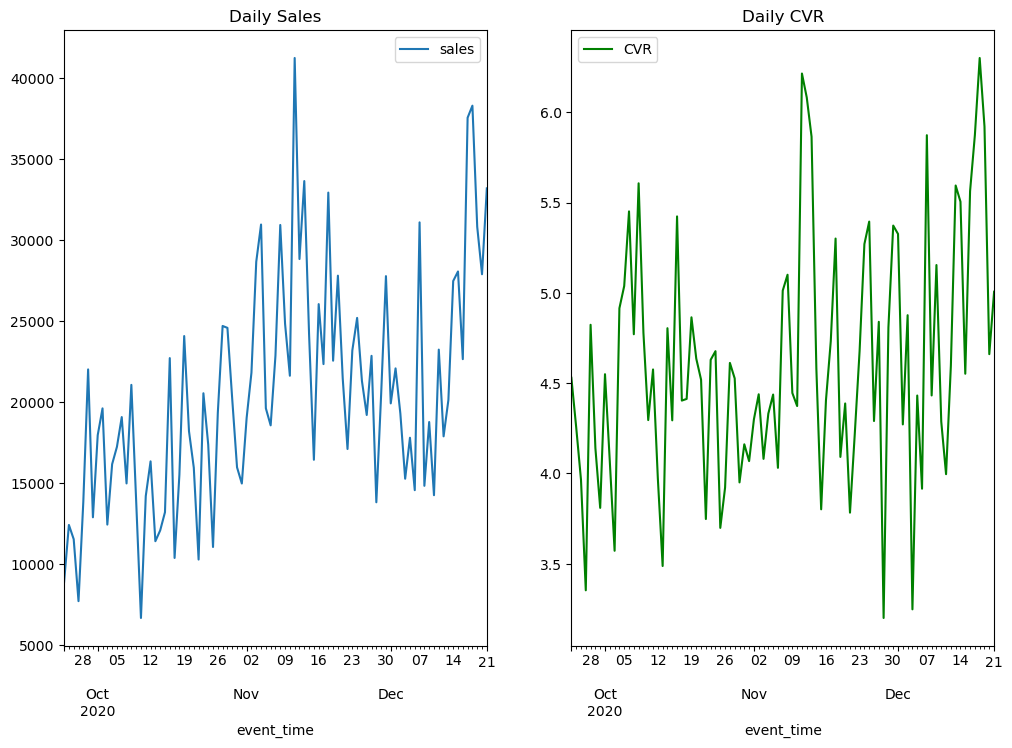

In [47]:
# 일일 매출, CVR 시각화
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

sales_line = df_cvr_sales.plot(x="event_time", y="sales", ax=axes[0])
sales_line.set_title("Daily Sales")

cvr_line = df_cvr_sales.plot(x="event_time", y="CVR", color="green", ax=axes[1])
cvr_line.set_title("Daily CVR")

### CVR 분석 결과
- 전체적으로 Daily Sales와 Daily CVR 같은 방향으로 움직인다
- 10월 말 ~ 11월 초
    - Sales는 상승하는데, CVR은 높지 않음
    - 전체적으로 클릭 수는 많지만, 구매까지 이어지는 비율이 낮다
    - 왜? 도메인 지식이 필요할듯

- 특별히 Sales, CVR 높은 기간 : 11월 둘째 주 및 12월 중순
    - 11월 둘째 주 : 도메인에 따른 영향으로 보임
    - 12월 중순 : 크리스마스 때문에 높을듯?

In [48]:
# ## 생각해볼 것
# - 고객 행동 분석
#     - 전체적으로 월요일에 view, cart, purchase 횟수가 많다
#         - 월요일에 특정 Action Plan 가져갈 수 있을까?
#     - 시간대별 그래프도 view, cart, purchase 거의 비슷한 양상이지만, 17시 ~ 19시 사이 그래프 모양이 좀 다르다
#         - purchase 오전 10시에 높지만, view, cart에 비해 17시 ~ 19시는 낮다

# ## 추가 진행 요소
# - 결측치 처리 방법
# - CVR 다시 구해보기
# - 퍼널, 코호트 분석


## 퍼널 분석

### 퍼널분석이란?
- 유저가 서비스 접속 후 상품을 구매하기까지 경로를 가시화하여 전환과 이탈률을 측정함으로서 집중 개선 대상 구간을 발견

- 고객이 유입되고 전환에 이르기까지의 주요 단계를 수치로 확인하는 고객 분석 방법
    - 전환에 이르는 고객 경험 프로레스를 단계별로 나누어 이탈하는 원인을 개선하고 전환율을 높이는 것이 목표

- 고객이 제품을 구매하는 프로세스를 분석해 고객 행동을 파악하고 마케팅 효과를 극대화 하는 것

- references
    - https://wikidocs.net/16576
    - https://m.blog.naver.com/jaehong7719/221984932475
    - https://bigsong.tistory.com/38
    - https://business.adobe.com/kr/blog/basics/funnels-analysis
    - https://velog.io/@kmnkit/Mini-Project%EC%87%BC%ED%95%91%EB%AA%B0-%EC%A3%BC%EB%AC%B8-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC-%ED%99%9C%EC%9A%A9%ED%95%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B6%84%EC%84%9D-5Log%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A5%BC-%ED%8C%8C%EC%95%85%ED%95%98%EC%97%AC-%EA%B3%A0%EA%B0%9D-%EC%9D%B4%ED%83%88-%ED%8E%98%EC%9D%B4%EC%A7%80-%ED%99%95%EC%9D%B8%ED%95%98%EA%B8%B0
    - https://wbin0718.github.io/project/shoppingmall_weblog_04/

#### 스텝 분류
- `event_type` 컬럼 기준
    - `view` = 1
    - `cart` = 2
    - `purchase` = 3

In [49]:
# 3가지 스텝 분류
funnel_dict = {"view" : 1,
               "cart" : 2,
               "purchase" : 3}

# 분류한 퍼널 스텝을 기반으로, 데이터 프레임 생성
funnel_steps = pd.DataFrame.from_dict(funnel_dict, orient='index', columns=['step_no'])
funnel_steps

,step_no
view,1
cart,2
purchase,3


#### 그룹핑
- `user_session`을 기준으로 하는 이유 : 동일한 유저가 다른 세션으로 접속한다면 별도의 건으로 간주해야 한다

In [50]:
# user_session과 event_type으로 groupby
# 가장 시간대가 빠른 해당 이벤트에 대해 추출
grouped = df.groupby(["user_session", "event_type"])["event_time"].agg(np.min)
grouped = pd.DataFrame(grouped)
grouped.head()

,,event_time
user_session,event_type,
000c34fa-991f-442a-8e07-8c472269bec6,view,2020-09-30 17:52:02+00:00
001P7lK0Pt,view,2020-11-06 01:25:30+00:00
002DmERG1w,view,2020-09-26 18:59:06+00:00
003QqC0jk0,view,2020-10-25 15:23:25+00:00
003pEktS1X,view,2020-11-02 18:11:24+00:00


In [51]:
grouped = grouped.merge(funnel_steps, left_on="event_type", right_index=True)
grouped.tail()

,,event_time,step_no
user_session,event_type,,
zzM79K5zNh,cart,2020-12-21 11:48:18+00:00,2
zzPhVNhJaW,cart,2020-11-09 05:06:34+00:00,2
zzS1Y8qulW,cart,2020-12-03 07:54:38+00:00,2
zzYrsY8eed,cart,2020-11-20 12:32:36+00:00,2
zzfih3qogN,cart,2020-11-12 08:21:36+00:00,2


In [52]:
grouped.shape

(262741, 2)

#### 퍼널 테이블 생성
- 각 퍼널의 스텝이 순서대로 column에 자리하게 변경
- `pivot_table` 이용하여, `user_session` 별로 퍼널 스텝 진행 여부를 확인

In [53]:
# pivot table 생성
funnel = grouped.reset_index().pivot(index="user_session", columns="step_no", values="event_time")
funnel.columns = funnel_steps.index
funnel.head()

,view,cart,purchase
user_session,,,
000c34fa-991f-442a-8e07-8c472269bec6,2020-09-30 17:52:02+00:00,NaT,NaT
001P7lK0Pt,2020-11-06 01:25:30+00:00,NaT,NaT
002DmERG1w,2020-09-26 18:59:06+00:00,NaT,NaT
003QqC0jk0,2020-10-25 15:23:25+00:00,NaT,NaT
003pEktS1X,2020-11-02 18:11:24+00:00,NaT,NaT


In [54]:
# view에서 그치는 경우, cart까지 가는 경우, purchase까지 완료하는 경우를 각각 계산하여 step_values로 만든다
# cart, purchase는 앞 단계가 있어야 진행되기 때문에, notnull()을 사용하여 확인하면 자동으로 퍼널 스텝이 이어진다고 볼 수 있다

step_values = [funnel[index].notnull().sum() for index in funnel_steps.index]
step_values

[233197, 18460, 11084]

In [55]:
# plotly 사용해서 퍼널 그래프 시각화

df_funnel = dict(step_values=step_values,
                 funnel_steps=funnel_steps.index)
fig = px.funnel(df_funnel, x="step_values", y="funnel_steps")
fig.show()

In [56]:
# 퍼널 별 소요시간 계산

# view -> cart 걸리는 시간
print(np.mean(funnel["cart"] - funnel["view"]))

# cart -> purchase 걸리는 시간
print(np.mean(funnel["purchase"] - funnel["cart"]))

0 days 05:04:00.263465915
0 days 01:24:57.586591004


In [57]:
# 각 퍼널 별 전환율
funnel_cvr = pd.DataFrame({"view → cart" : step_values[1]/step_values[0]*100,
                           "cart → purchase" : step_values[2]/step_values[1]*100},
                           index=["funnel_cvr"])
funnel_cvr

,view → cart,cart → purchase
funnel_cvr,7.916054,60.043337


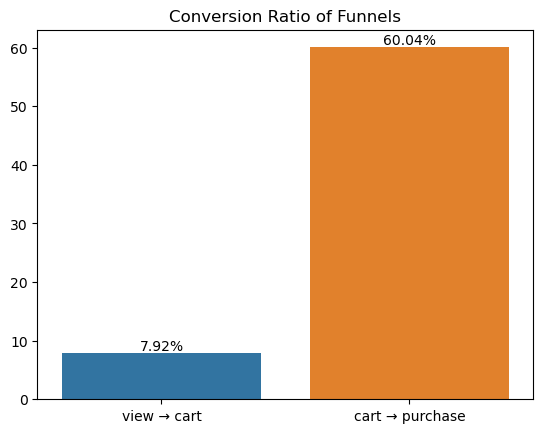

In [58]:
# 각 퍼널 별 전환율 시각화
ax = sns.barplot(data=funnel_cvr)
plt.title("Conversion Ratio of Funnels")

for i, line in enumerate(ax.patches):
    ax.text(line.get_x() + line.get_width() / 2,
            line.get_height() + 0.5,
            "{:.2f}%".format(funnel_cvr.iloc[0][i]), ha="center")

### 퍼널 분석 결과
- `view → cart`로 이어지는 구간의 전환률이 매우 낮다 **(약 0.8%)**
- `cart → purchase`로 이어지는 구간은 앞선 구간에 비해 전환률 높다 **(약 60%)**

- 전환률을 10% 올린다면, `view → cart` 구간의 전환율을 높이는 것이 효과적
    - `view` `user_session` : 233197
        - 10% 상승 : 약 23319
    - `cart` `user_session` : 18460
        - 10% 상승 : 약 1846
* → `view → cart` 구간의 전환률을 높일 수 있는 비즈니스 액션 플랜이 필요하다
* → `view → cart` 구간의 전환률을 높일 수 있는 UI 해결책도 도출 필요 (AB Test 등)

## 코호트 분석

### 코호트 분석이란?
- 동일한 기간 동안 동일한 특성을 가진 사람의 집단 모아 분석하는 일종의 **행동 분석** 
    - 일정한 기준으로 사용자를 묶는다
- 실무적으로는 고객의 **이탈률** (Exit Rate)과 **재구매율** (Retention Rate)을 파악하여 정기적으로 문제를 진단하고, 해결 전략을 도출하기 위한 대시보드로 많이 활용
    - 고객 집단별로 **고객 생애 가치** (LTV)를 계산하고, 서비스의 **고착도** (Stickness)를 판단하는 중요한 수단
        - 고착도 : $DAU/MAU$, 월간 순수 사용자 중 특정 일자에 접속한 사람의 비율, 유저가 더 자주 방문할수록 고착도는 100%에 가까워진다

- 장점
    - 유저 집단 분석을 통헤 서비스의 기능 개선
    - 유저들의 참여도 및 이용률 상승
    - 코호트를 통해, 유저 행동을 깊게 이해할 수 있고 어떻게 변화하는지도 알 수 있다

- references
    - https://brunch.co.kr/@549e04bfaf574b0/15
    - https://data-marketing-bk.tistory.com/entry/Python-COHORT-%EB%B6%84%EC%84%9D-%EA%B0%9C%EB%85%90%EB%B6%80%ED%84%B0-%EC%8B%A4%EC%A0%84-%EC%BD%94%EB%93%9C%EA%B9%8C%EC%A7%80-feat-%EB%B6%84%EC%84%9D-%EC%98%88%EC%A0%9C-%ED%8F%AC%ED%95%A8

#### 코호트 분석을 통해 분석 가능한 데이터

- 전환률 (conversion rates)

- 리텐션률 (Retention rates)

- 이용자의 목표 달성률 (Goal completions per user)

- 이용자의 수익률 (Revenue per user)

- 이용자 당 세션 (sessions per user)

- 이용자 당 페이지 뷰 수 (Page views per user)

- 이용자 당 세션 기간 (얼마나 오래 머물러 있는지) (session duration per user)

- 이용자당 전환률 (transactions per user)

In [59]:
df.head()

,event_time,month,day,day_name,hour,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,cat_code_1,cat_code_2,cat_code_3
0,2020-09-24 11:57:06+00:00,9,24,Thursday,11,view,1996170,2.140000e+18,electronics.telephone,pitatel,31.9,1.520000e+18,LJuJVLEjPT,electronics,telephone,no_cat
1,2020-09-24 13:58:51+00:00,9,24,Thursday,13,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,IBu02xVrhQ,computers,notebook,no_cat
2,2020-09-24 14:00:24+00:00,9,24,Thursday,14,view,790590,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,l68Br3I0Tl,computers,notebook,no_cat
3,2020-09-25 08:36:13+00:00,9,25,Friday,8,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,6fTFbeiEqq,computers,notebook,no_cat
4,2020-09-30 16:16:16+00:00,9,30,Wednesday,16,view,751693,2.140000e+18,computers.notebook,pitatel,31.9,1.520000e+18,poHN5cBucr,computers,notebook,no_cat


In [60]:
# 유저를 파악할 수 있는 컬럼 : user_id
# → user_id가 하나로 통일되어 있어, 여러 유저들을 가를 수가 없다
df.user_id.value_counts()

user_id
1.520000e+18    407913
Name: count, dtype: int64

### 적용하기 힘든 이유
- 유저를 행동에 따라 파악할 수 있는 기준 부재
    - 유저를 파악할 수 있는 컬럼이 `user_id` 하나 뿐인데, 값이 모두 통일되어 있다

- 따라서, 행동에 기반하여 유저가 이탈하거나 재구매하는 여부를 확인할 수 없음
- 추후, 다른 이커머스 데이터를 보충하거나 추가하여 다시 데이터 분석 실시할 때, 코호트 분석 실시 예정

## 장바구니, 구매 금액 Top 5 제품

In [61]:
df_grp = df.groupby(["event_type"])

In [62]:
df_grp.get_group("view").groupby("category_code")["price"].agg([np.sum]).sort_values("sum", ascending=False)[:5]

,sum
category_code,
computers.components.videocards,7801422.30
electronics.video.tv,4833928.68
computers.peripherals.printer,4259618.77
electronics.telephone,4079603.74
computers.components.cpu,2409060.75


In [63]:
# df[df.event_type=="view"]["category_code"].value_counts(normalize=True)[:5]
df_grp.get_group("cart").groupby("category_code")["price"].agg([np.sum]).sort_values("sum", ascending=False)[:5]

,sum
category_code,
computers.components.videocards,926294.39
computers.peripherals.printer,324122.39
computers.components.cpu,255488.71
electronics.telephone,163882.44
computers.components.motherboard,99282.24


In [64]:
# df[df.event_type=="cart"]["category_code"].value_counts(normalize=True)[:5]
df_grp.get_group("purchase").groupby("category_code")["price"].agg([np.sum]).sort_values("sum", ascending=False)[:5]

,sum
category_code,
computers.components.videocards,517941.24
computers.peripherals.printer,249335.02
computers.components.cpu,137177.15
electronics.telephone,95669.60
stationery.cartrige,67012.20


In [65]:
# cart에 넣은 제품 Top 5 가격이 전체 cart에서 차지하는 비율
cart_pr_top_5 = np.sum(df_grp.get_group("cart").groupby("category_code")["price"].agg([np.sum]).sort_values("sum", ascending=False)[:5])
cart_pr_total = np.sum(df_grp.get_group("cart").groupby("category_code")["price"].agg([np.sum]).sort_values("sum", ascending=False))

cart_pr_top_5 / cart_pr_total * 100

sum    61.223229
dtype: float64

### Top 5 제품 특징
- Top 5 매출 제품 목록 대부분이 **고관여 상품**
    - videocards, printer, cpu, telephone 등등

- 고관여 vs 저관여 상품
    - 고관여 상품의 특징
        - 일반적으로 가격이 비싸서 구매에 대한 리스크가 높다
        - 구매를 결정하기까지 오랜 시간이 소요됨
        - 가전제품, 가구 등
    - 저관여 상품의 특징
        - 상품 구매의 리스크가 낮아 길게 고민하지 않고 구입 가능한 상품
        - 습관적, 즉흥적으로 구매
        - 식품, 생활용품 등

In [66]:
# count_cat_code = df.groupby(["user_session", "day_name", "event_type", "category_code"])[["category_code"]].agg(["count", "max"])
# count_cat_code = df.groupby(["user_session", "day_name", "event_type", "category_code"])["day_name"].agg(["count"])
count_cat_code = df.groupby(["user_session", "day_name", "event_type", "category_code"])["price"].agg(["sum"])
count_cat_code.head()

,,,,sum
user_session,day_name,event_type,category_code,
000c34fa-991f-442a-8e07-8c472269bec6,Wednesday,view,electronics.tablet,421.22
001P7lK0Pt,Friday,view,electronics.audio.headphone,167.70
002DmERG1w,Saturday,view,computers.components.tv_tuner,27.95
003QqC0jk0,Sunday,view,auto.accessories.player,62.22
003pEktS1X,Monday,view,computers.peripherals.printer,9.84


In [67]:
day_cat_code = count_cat_code.reset_index()
day_cat_code.head()

,user_session,day_name,event_type,category_code,sum
0,000c34fa-991f-442a-8e07-8c472269bec6,Wednesday,view,electronics.tablet,421.22
1,001P7lK0Pt,Friday,view,electronics.audio.headphone,167.70
2,002DmERG1w,Saturday,view,computers.components.tv_tuner,27.95
3,003QqC0jk0,Sunday,view,auto.accessories.player,62.22
4,003pEktS1X,Monday,view,computers.peripherals.printer,9.84


In [68]:
day_cat_code_cart = day_cat_code[day_cat_code.event_type=="cart"]
day_cat_code_cart.head()

,user_session,day_name,event_type,category_code,sum
11,00735945-0395-48db-967c-59418c0ddb89,Wednesday,cart,electronics.telephone,70.00
18,00B4xBIIZJ,Sunday,cart,computers.components.videocards,292.83
39,00RLUrffvt,Tuesday,cart,computers.ebooks,257.87
46,00XkV8sbFR,Thursday,cart,computers.components.cpu,82.33
56,00hzdTsP0l,Sunday,cart,electronics.audio.acoustic,107.33


In [69]:
# category_code top 5인 것들 리스트로 생성
cart_cat_top_5 = df_grp.get_group("purchase").groupby("category_code")["price"].agg([np.sum]).sort_values("sum", ascending=False)[:5].index.tolist()
cart_cat_top_5

['computers.components.videocards',
 'computers.peripherals.printer',
 'computers.components.cpu',
 'electronics.telephone',
 'stationery.cartrige']

In [70]:
# 빈 데이터프레임 생성
null_df = pd.DataFrame(columns=day_cat_code_cart.columns)

In [71]:
# 빈 데이터프레임에 category_code에 해당하는 데이터프레임 concat하여 하나의 데이터프레임으로 생성
for column in cart_cat_top_5:
    cat_group = day_cat_code_cart.groupby("category_code").get_group(column)
    null_df = pd.concat([null_df, cat_group])

In [72]:
top5_df = null_df.rename(columns={"sum":"price_sum"})
top5_df.head()

,user_session,day_name,event_type,category_code,price_sum
18,00B4xBIIZJ,Sunday,cart,computers.components.videocards,292.83
140,01mP1vWIfs,Tuesday,cart,computers.components.videocards,415.54
376,04oyzlGDZn,Thursday,cart,computers.components.videocards,202.67
434,05Ljgh0Sku,Sunday,cart,computers.components.videocards,915.25
566,074oxPIksq,Sunday,cart,computers.components.videocards,202.67


In [73]:
top5_df["category_code"].value_counts()

category_code
electronics.telephone              3098
computers.components.videocards    2027
computers.peripherals.printer      1924
stationery.cartrige                1738
computers.components.cpu           1220
Name: count, dtype: int64

#### 시각화

<Axes: xlabel='day_name', ylabel='price_sum'>

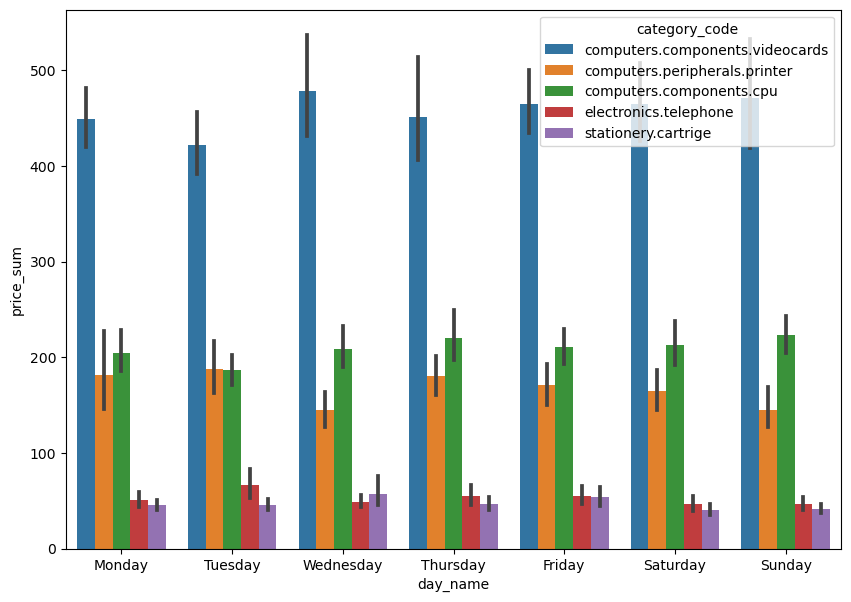

In [74]:
hue_order = cart_cat_top_5

plt.figure(figsize = (10, 7))
sns.barplot(data=top5_df, 
            x="day_name", 
            y="price_sum",
            hue="category_code", 
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
            hue_order=hue_order)

#### 시각화 결과
- 요일별로 전체적으로 비슷한 판매량 기록

- 전반적으로 컴퓨터 주변기기의 판매량이 높음
    - 그 중 `videocards`의 매출액이 압도적으로 높다
    - 컴퓨터 주변기기, 특히 `videocards`를 집중적으로 프로모션 하는 것도 좋은 방법일듯

## 가설설정
- 가설 1
    - 주말 (토, 일, 월)과 평일 (화, 수, 목, 금)의 매출액 평균이 차이날 것이다
        - 통계적으로 확인해보고 싶었으나, 적용 실패
        - 추후 공부하여 보강 예정
- 가설 2 (추가 예정)

## 액션 플랜
- 문제
    - `view → cart` 구간의 전환률이 떨어진다
    * → `view → cart` 구간의 전환률을 높일 수 있는 비즈니스 액션 플랜이 필요하다

    * → `view → cart` 구간의 전환률을 높일 수 있는 UI 해결책도 도출 필요 (AB Test 등)

- 해결책
    - 당장 물건을 구매할 생각이 없는 고객
        -`videocards`,`printer`, `cpu`, `telephone`, 모두 고관여 상품
        - 고관여 상품은 재구매 주기가 길고 고객이 다양한 정보를 비교하는 성향이 있다
            - 구매에 이르는 의사결정 과정이 길다 (신중하게 상품과 정보에 접근)
        - 고객에게 할인 행사 및 세일하는 가격을 주기적으로 어필하여, 고객 경험을 강화한다

- 해결책 2)
    - 고객이 방대한 카테고리와 상품을 마주한다
        - 그만큼, **원하는 상품 한번에 파악하기 힘들다**
        
        - 캠페인 타겟
            - `user_session` 기준으로 해당 상품과 `category` 처음 접하는 고객
        - 처음 `view` 하는 고객이 매력을 느낄만한 가격대의 상품 추천 팝업 통해, 고객의 추가적인 활동 자연스레 유도한다
        - `user_sesseion`과 `category`를 기준하여, 처음 방문한 고객을 대상으로 해당 `category`의 베스트 상품을 추천하는 `이달의 추천 상품 팝업` 캠페인 제안
    - 쿠폰 및 할인 행사 유도 팝업 캠페인
        - 캠페인 타겟
            - `평일 (월-금), 퇴근 시간 (19시 이후)` 이동하며 쇼핑몰에 접속하는 고객
        - 단순 `view` 하는 고객의 시선을 끌기 위해, 관련 카테고리의 할인 행사 및 기획전을 인지시켜 고객의 웹사이트 체류 시간을 높이고 추가 활동을 츄도한다
            - ex) 무료 배송 및 반품 쿠폰, 후불 결제 기능 등
        - 다양한 쿠폰과 할인 상품을 한꺼번에 보여줄 수 있는 쿠폰을 상품 첫 페이지에 노출시켜, 고객의 마음을 사로잡는 `쿠폰 및 할인 유도 팝업` 캠페인 제안

- 기대 효과
    - 쿠폰 및 할인 유도를 통해 고관여 제품 구매의 심리적 장벽을 낮추고, 추가적인 상품 탐색 기회 제공